# Task 1: EDA

In [ ]:
#  Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For regression models and evaluation later
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv("hour.csv")  # Make sure hour.csv is in the same directory or provide full path

# Display first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Basic info
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

First 5 rows of the dataset:
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379

We removed the following columns from the dataset:

- Instant: it is just a unique id for each row, doesnt add any predictive value

- dteday: A string version of the date. Since we already have features like year (yr), month (mnth), and day of the week (weekday), this becomes redundant.

- casual and registered: These two columns together directly sum up to the target variable (cnt), which represents the total bike rentals. Keeping them would be a form of data leakage because the model would learn the target from its components instead of actual predictors.


In [2]:
df.drop(columns=['instant', 'dteday', 'casual', 'registered'], inplace=True)

### EDA Visualizations

<Figure size 1200x600 with 0 Axes>

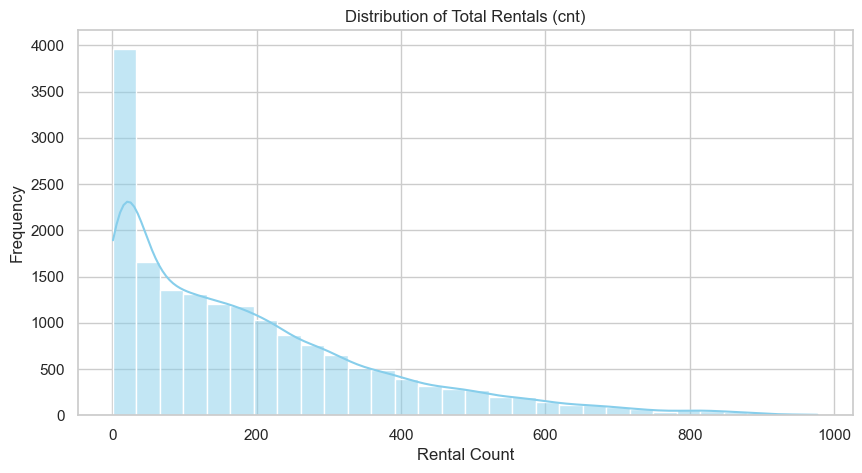

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# 1. Distribution of Total Rentals (cnt)
plt.figure(figsize=(10, 5))
sns.histplot(df['cnt'], kde=True, bins=30, color="skyblue")
plt.title("Distribution of Total Rentals (cnt)")
plt.xlabel("Rental Count")
plt.ylabel("Frequency")
plt.show()

Helps us understand how bike rentals are distributed. The histogram shows that most bike rental sessions fall on the lower end of the scale, with a noticeable right skew. This makes sense because high rental spikes are rarer, while lower or moderate rental volumes are more common. The peak is strong in the 0-100 rental range and then it gradually decreases. High rental counts are much more rare, which is somethign that we were expecting.


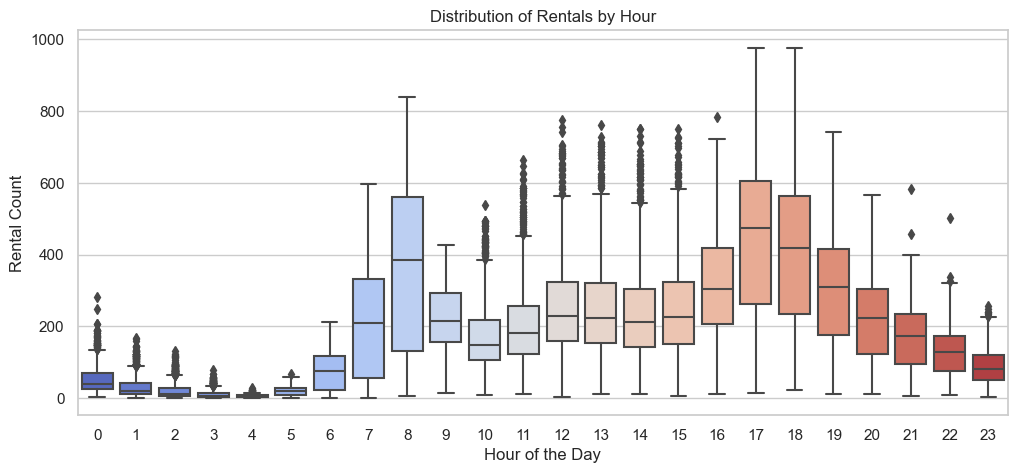

In [4]:
# 2. Rentals by Hour of the Day
plt.figure(figsize=(12, 5))
sns.boxplot(x='hr', y='cnt', data=df, palette="coolwarm")
plt.title("Distribution of Rentals by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Rental Count")
plt.show()

Shows usage trends by hour. We can see that there are 2 noticeable peaks which are morning hours around 8AM and afternoon around 5-6PM. This makes sense as they are likely the typical commuting hours. We can also see that early in the morning there are far few less people who rent bikes (2-5AM)

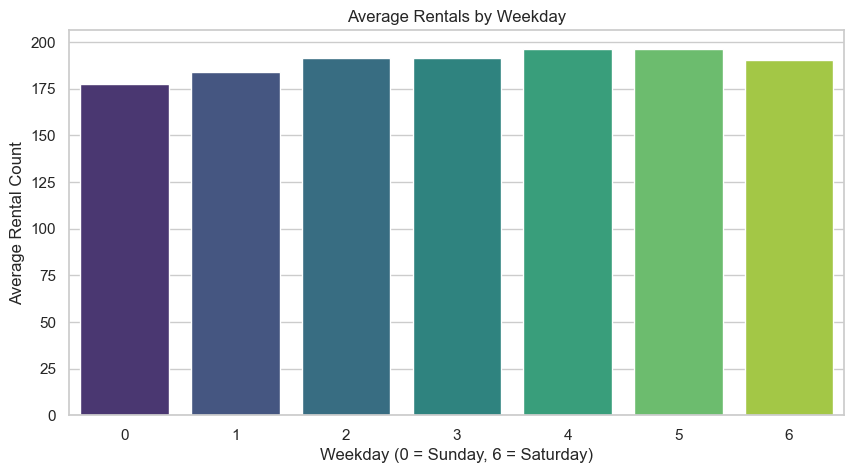

In [5]:
# 3. Average Rentals by Weekday
plt.figure(figsize=(10, 5))
weekday_avg = df.groupby("weekday")["cnt"].mean().reset_index()
sns.barplot(x="weekday", y="cnt", data=weekday_avg, palette="viridis")
plt.title("Average Rentals by Weekday")
plt.xlabel("Weekday (0 = Sunday, 6 = Saturday)")
plt.ylabel("Average Rental Count")
plt.show()

Helps spot trends across weekdays. We can see that the rentals stay pretty consistent during weekends as well as weekdays. There are more rentals on Thursdays-Fridays, but in general it stays pretty consistent. Although Sunday is the day with the least rentals, its not highly significant. We can assume then that they use bikes for commuting as well as for leisure.

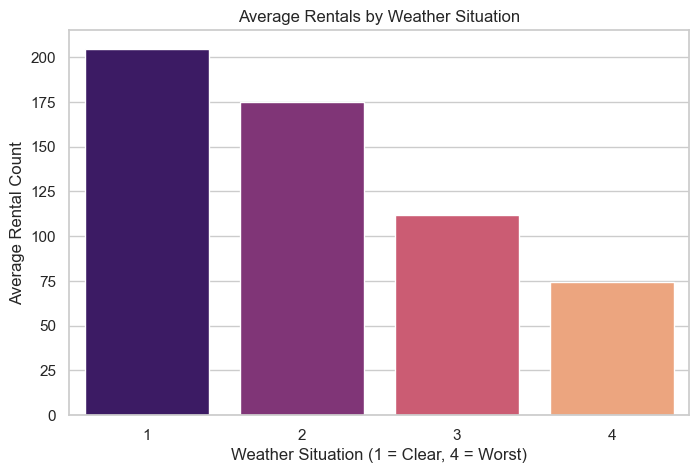

In [6]:
# 4. Rentals by Weather Situation
plt.figure(figsize=(8, 5))
weather_avg = df.groupby("weathersit")["cnt"].mean().reset_index()
sns.barplot(x="weathersit", y="cnt", data=weather_avg, palette="magma")
plt.title("Average Rentals by Weather Situation")
plt.xlabel("Weather Situation (1 = Clear, 4 = Worst)")
plt.ylabel("Average Rental Count")
plt.show()

Explores how external weather conditions affect bike usage. As we would expect in our data there is a negative correlation between poor weather and bike rental. The highest rental count occurs when the weathcer is clear and it drops as the weather also drops.

#### Correlation plot

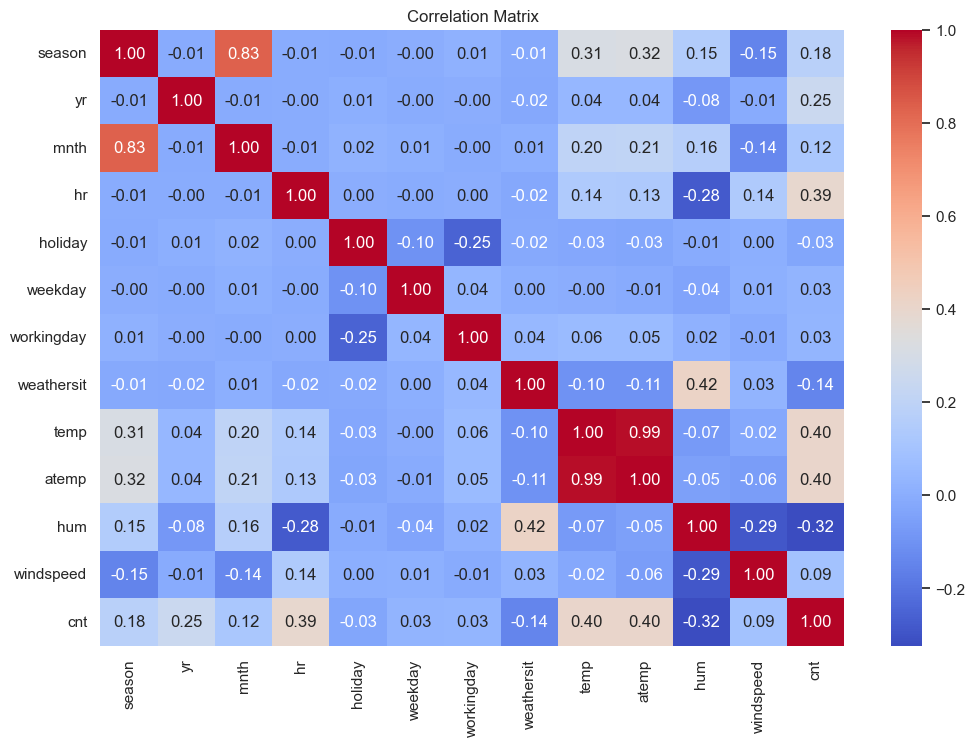

In [7]:
numeric_df = df.select_dtypes(include='number')

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

We probably should drop atemp as it is highly correlated with temp

# Task 2: Data Splitting

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate target and features
X = df.drop(columns=['cnt'])  # 'cnt' is the target variable
y = df['cnt']

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=13)

# Second split: 20% val, 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=13)

# Show the result
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (10427, 12)
Validation set shape: (3476, 12)
Test set shape: (3476, 12)


I split the data into 3 sets: 60% for training, 20% for validation, and 20% for testing. I did this by using train_test_split, ensuring that the model has enough data to learn from patters, enough separate data to tune parameters, and untouched data in order to evaluate performance.

We are doing this before of feature engineering in order to avoid data leakage. We don't want any over optimistic performance and poor generalization.


# Task 3: Feature Engineering

We have to encode cyclical features because there is a circular nature. hour 0 and hour 23 are right next to each other, not that far away. The same thing happens with weekdays, monday and sunday are right next to each other. We used sine and cosine in order to capture patterns that repeat cyclically so now it will be between -1 and 1.

In [ ]:
# Save original hr and weekday for visualization
print("Previewing original 'hr' and 'weekday' before encoding:")
print(X_train[['hr', 'weekday']].head() if 'hr' in X_train.columns and 'weekday' in X_train.columns else "Already dropped!")

# Cyclical Encoding Function 
def encode_cyclical_feature(df, column, max_val):
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / max_val)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / max_val)
    return df

# Only apply encoding if columns still exist
for cyclical_col, max_val in [('hr', 24), ('weekday', 7)]:
    if cyclical_col in X_train.columns:
        X_train = encode_cyclical_feature(X_train, cyclical_col, max_val)
        X_val = encode_cyclical_feature(X_val, cyclical_col, max_val)
        X_test = encode_cyclical_feature(X_test, cyclical_col, max_val)

# Show encoded columns
print("\nAfter cyclical encoding:")
cyclic_cols = ['hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos']
available_cyclic = [col for col in cyclic_cols if col in X_train.columns]
print(X_train[available_cyclic].head())

# Drop original cols if not already dropped
for col in ['hr', 'weekday']:
    for dataset in [X_train, X_val, X_test]:
        if col in dataset.columns:
            dataset.drop(columns=[col], inplace=True)

Previewing original 'hr' and 'weekday' before encoding:
       hr  weekday
14779   0        4
16914  13        3
15863   4        0
4204    2        3
1554    5        4

After cyclical encoding:
         hr_sin    hr_cos  weekday_sin  weekday_cos
14779  0.000000  1.000000    -0.433884    -0.900969
16914 -0.258819 -0.965926     0.433884    -0.900969
15863  0.866025  0.500000     0.000000     1.000000
4204   0.500000  0.866025     0.433884    -0.900969
1554   0.965926  0.258819    -0.433884    -0.900969


I also applied one-hot econding to season, weathersit, and month. This will convert them into binary variables, this is done because these variables are cateogrical.  We dont want the labels to be seen as magnitudes. 

In [10]:
X_train_original = X_train.copy()
# Preview unique values before encoding
print("Before One-Hot Encoding:")
print("Season unique values:", X_train_original['season'].unique())
print("Weathersit unique values:", X_train_original['weathersit'].unique())
print("Month unique values:", X_train_original['mnth'].unique())

# One-hot encoding
categorical_cols = ['season', 'weathersit', 'mnth']
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_val = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Re-align columns to ensure consistent shapes
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Check encoded columns
print("\nAfter One-Hot Encoding (sample of columns):")
encoded_cols = [col for col in X_train.columns if any(cat in col for cat in ['season_', 'weathersit_', 'mnth_'])]
print(X_train[encoded_cols].head())

Before One-Hot Encoding:
Season unique values: [3 4 1 2]
Weathersit unique values: [1 2 3 4]
Month unique values: [ 9 12 10  6  3  2  5 11  1  7  8  4]

After One-Hot Encoding (sample of columns):
       season_2  season_3  season_4  weathersit_2  weathersit_3  weathersit_4  \
14779     False      True     False         False         False         False   
16914     False     False      True          True         False         False   
15863     False     False      True          True         False         False   
4204      False      True     False         False         False         False   
1554      False     False     False         False          True         False   

       mnth_2  mnth_3  mnth_4  mnth_5  mnth_6  mnth_7  mnth_8  mnth_9  \
14779   False   False   False   False   False   False   False    True   
16914   False   False   False   False   False   False   False   False   
15863   False   False   False   False   False   False   False   False   
4204    False   False   

I did scaling because it ensures that features with different ranges are brought to a similar scale. So it makes everything fair as it is working on the same scale instead of giving more importance to variables which ranges are with bigger numbers.

In [11]:
# Store a copy of the original (before scaling)
X_train_before_scaling = X_train.copy()

# Apply scaling
scaler = StandardScaler()
cont_cols = ['temp', 'atemp', 'hum', 'windspeed']
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_val[cont_cols] = scaler.transform(X_val[cont_cols])
X_test[cont_cols] = scaler.transform(X_test[cont_cols])

# Visualize the effect
print("Before Scaling:")
print(X_train_before_scaling[cont_cols].describe())

print("\nAfter Scaling:")
print(X_train[cont_cols].describe())


Before Scaling:
               temp         atemp           hum     windspeed
count  10427.000000  10427.000000  10427.000000  10427.000000
mean       0.496436      0.475479      0.626612      0.190609
std        0.193049      0.172721      0.192536      0.121860
min        0.020000      0.000000      0.000000      0.000000
25%        0.340000      0.333300      0.480000      0.104500
50%        0.500000      0.484800      0.620000      0.194000
75%        0.660000      0.621200      0.780000      0.253700
max        1.000000      1.000000      1.000000      0.850700

After Scaling:
               temp         atemp           hum     windspeed
count  1.042700e+04  1.042700e+04  1.042700e+04  1.042700e+04
mean  -1.454885e-16 -2.524754e-16 -4.054598e-16  1.011946e-16
std    1.000048e+00  1.000048e+00  1.000048e+00  1.000048e+00
min   -2.468067e+00 -2.753011e+00 -3.254674e+00 -1.564243e+00
25%   -8.103813e-01 -8.232137e-01 -7.615134e-01 -7.066588e-01
50%    1.846157e-02  5.396689e-02 -3.4

I added an interaction term between temp and humidity. This was because of the idea that hot + humid conditions might impact bike usage differently than hot + dry weather. We noticed in EDA that both features independently affected usage, so combining them may help uncover non-linear relationships.

We did hr and working day because rush hour peaks only happen on working days and weekend patterns are different even at the same hour

We also added season and weathersit because they don’t operate independently and their combined context can strongly influence bike rental behavior. A rainy or foggy day (weathersit) in summer might still result in high rentals because it’s warm and people are more likely to go out. But the same weathersit in winter could drastically reduce rentals due to already low temperatures and less daylight. This can be a great interaction to look out for
	



In [12]:
X_train['temp_hum'] = X_train['temp'] * X_train['hum']
X_val['temp_hum'] = X_val['temp'] * X_val['hum']
X_test['temp_hum'] = X_test['temp'] * X_test['hum']

X_train['hr_workingday'] = X_train['hr_cos'] * X_train['workingday']  # using encoded hr
X_val['hr_workingday'] = X_val['hr_cos'] * X_val['workingday']
X_test['hr_workingday'] = X_test['hr_cos'] * X_test['workingday']

X_train['season_weathersit'] = X_train['season_2'] * X_train['weathersit_2'] if 'season_2' in X_train and 'weathersit_2' in X_train else 0
X_val['season_weathersit'] = X_val['season_2'] * X_val['weathersit_2'] if 'season_2' in X_val and 'weathersit_2' in X_val else 0
X_test['season_weathersit'] = X_test['season_2'] * X_test['weathersit_2'] if 'season_2' in X_test and 'weathersit_2' in X_test else 0

print("\nSample interaction terms:")
print(X_train[['temp_hum', 'hr_workingday', 'season_weathersit']].head())


Sample interaction terms:
       temp_hum  hr_workingday  season_weathersit
14779  0.176825       1.000000              False
16914  0.869668      -0.965926              False
15863  0.000325       0.000000              False
4204   0.895106       0.866025              False
1554   2.300325       0.258819              False


After reviewing the correlation matrix in Task 1, I found that atemp (feels-like temperature) is highly correlated with temp. Including both might introduce multicollinearity. So I dropped atemp to reduce redundancy and make the model more interpretable.

In [13]:
X_train.drop(columns=['atemp'], inplace=True)
X_val.drop(columns=['atemp'], inplace=True)
X_test.drop(columns=['atemp'], inplace=True)

# Task 4: Baseline Model - Linear Regression

Lets first reload the original dataset and split it, then we can start training a simple linear regression without the encoding and evaluate how it works.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Reload the raw dataset
df_baseline = pd.read_csv("hour.csv")

#  Drop leaky and non-predictive columns
df_baseline.drop(columns=['instant', 'dteday', 'casual', 'registered'], inplace=True)

# Define features and target
X = df_baseline.drop(columns=['cnt'])  # Features
y = df_baseline['cnt']                 # Target

# Split into train, validation, test
X_train_b, X_temp_b, y_train_b, y_temp_b = train_test_split(X, y, test_size=0.2, random_state=42)
X_val_b, X_test_b, y_val_b, y_test_b = train_test_split(X_temp_b, y_temp_b, test_size=0.5, random_state=42)

In [ ]:
# Train baseline Linear Regression
baseline_model = LinearRegression()
baseline_model.fit(X_train_b, y_train_b)

# Predict on validation set
y_val_pred_b = baseline_model.predict(X_val_b)

# Evaluation Metrics
mse = mean_squared_error(y_val_b, y_val_pred_b)
mae = mean_absolute_error(y_val_b, y_val_pred_b)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_b, y_val_pred_b)

print("Baseline Model Evaluation on Validation Set:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Baseline Model Evaluation on Validation Set:
Mean Squared Error (MSE): 20150.19
Mean Absolute Error (MAE): 106.13
Root Mean Squared Error (RMSE): 141.95
R² Score: 0.3991


We can see that the model's prediction on the baseline are off by 142 rentals which is a lot. We can also see by the MAE that on average predictions are off by 106, regardless of the direction of the error. The MSE is 20,150 which means that the model is making significant prediciton mistakes. 
The model also explains roughly 40% of the variance in bike rentals meaning that there is a lot of the data's behavior that it doesnt capture in the model.

#### Plot - Actual vs Predicted

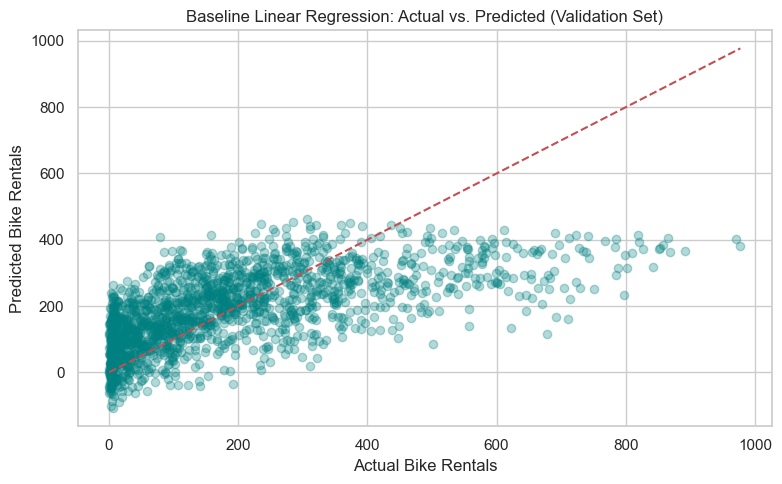

In [ ]:
#  Plot actual vs. predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_val_b, y_val_pred_b, alpha=0.3, color='teal')
plt.plot([y_val_b.min(), y_val_b.max()], [y_val_b.min(), y_val_b.max()], 'r--')
plt.xlabel("Actual Bike Rentals")
plt.ylabel("Predicted Bike Rentals")
plt.title("Baseline Linear Regression: Actual vs. Predicted (Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

The model is underestimating high rental counts as we can see by the points falling under the dotted line. 

#### Plot - Residual Distribution

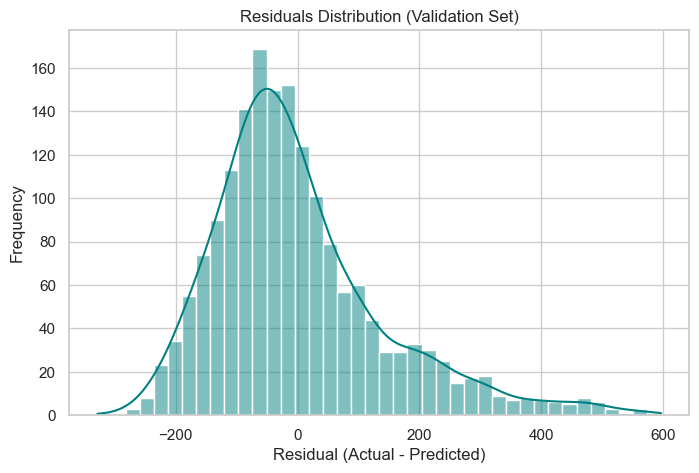

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

residuals = y_val_b - y_val_pred_b

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=40, color='teal')
plt.title("Residuals Distribution (Validation Set)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

We can see that the residuals are centered around 0, which is a good sign because it menans that its not significantly overpredicting or underpredicting. It is clearly skewed to the right though, which means that it underestimates the bike rentals on the higher end.

We would ideally like it to be more tihghtly concentrated around 0. This just means that the model is struggling with complex scenarios, so might be a bit biased right now. 

#### Plot - Residuals vs Predicted 

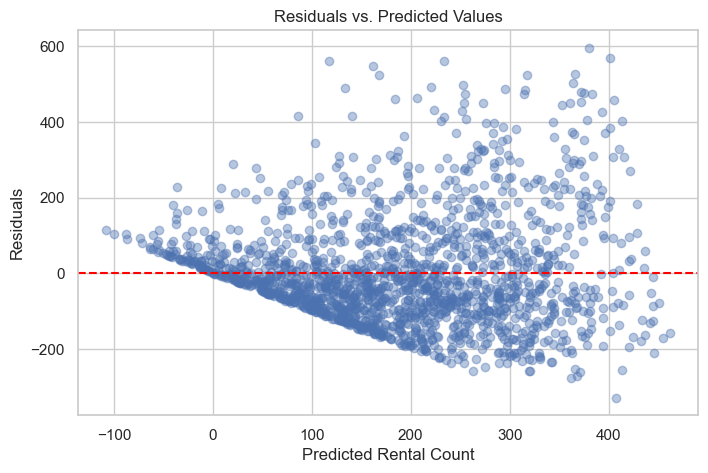

In [18]:
# Residuals vs. predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_val_pred_b, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Rental Count")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

We can see that the model performs worse whenever there's a higher number of rentals. We can see heteroscedasticity, which means that its errors are not consistent at all levels of prediction.

We can see that predictions for smaller rentals counts tend to be more accurate but as there are more rental counts there are more residuals meaning that there are underpredicting them. 


# Task 5: Random Forest Regressor

Here we will be using the already processed data.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_rf = rf_model.predict(X_val)

# Evaluation Metrics
mse_rf = mean_squared_error(y_val, y_val_pred_rf)
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_val, y_val_pred_rf)

# Print Results
print("Random Forest Evaluation on Validation Set:")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")

Random Forest Evaluation on Validation Set:
Mean Squared Error (MSE): 2139.29
Mean Absolute Error (MAE): 28.19
Root Mean Squared Error (RMSE): 46.25
R² Score: 0.9364


We can see that the random forest regressor performs better than the baseline model across all metrics. It reduces the MAE from 106 to 28, which is a great improvement. Also the RMSE went from 142 to 46, which is also huge improvement. Most importantly the R^2 went from 40% to 94% which means that it explains 94% of the variance in bike rentals. Really good.

We can see that the bike rental patterns are non-linear thats why the linear regression didnt do a great job, because it wasnt flexible enough.

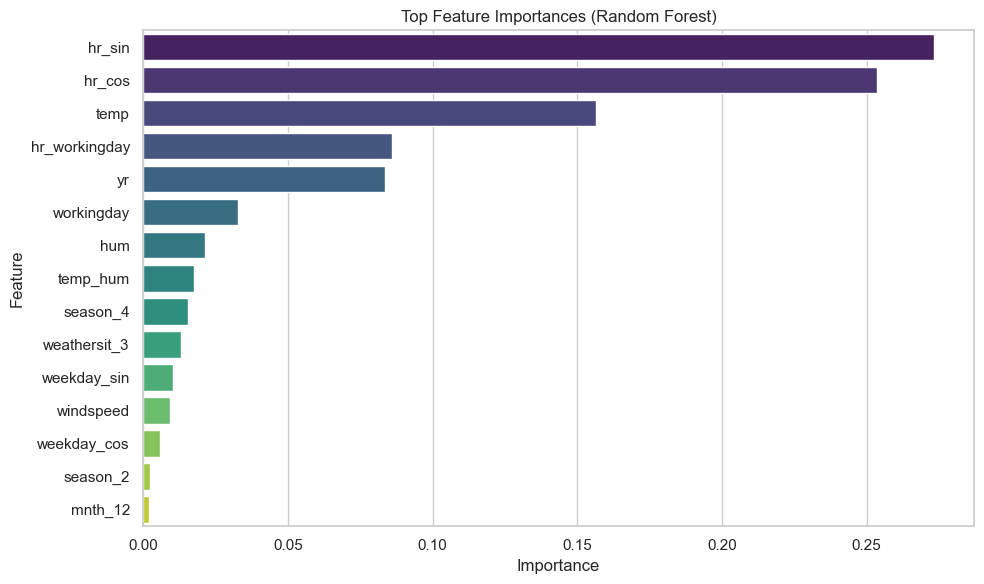

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

We can see that the most important features by far are the cyclically encoded hour values (hr_sin and hr_cos), which makes perfect sense because bike rental patterns follow daily cycles, with peaks likely during commute/rush hours.

Temperature is also a strong predictor, which aligns with the idea that people are more likely to rent bikes in warmer conditions. The interaction between hour and working day (hr_workingday) also ranks highly, which reflects how work schedules affect bike usage.

The year (yr) is also significant, suggesting an increasing trend in bike rentals over time. Other relevant features include working day status, humidity, and the interaction between temperature and humidity (temp_hum), all of which likely influence the comfort and practicality of biking.

#### Plot - Actual vs Predicted

In [ ]:
# Predict using the trained Random Forest model
y_val_rf = y_val       
y_val_pred_rf = rf_model.predict(X_val)  

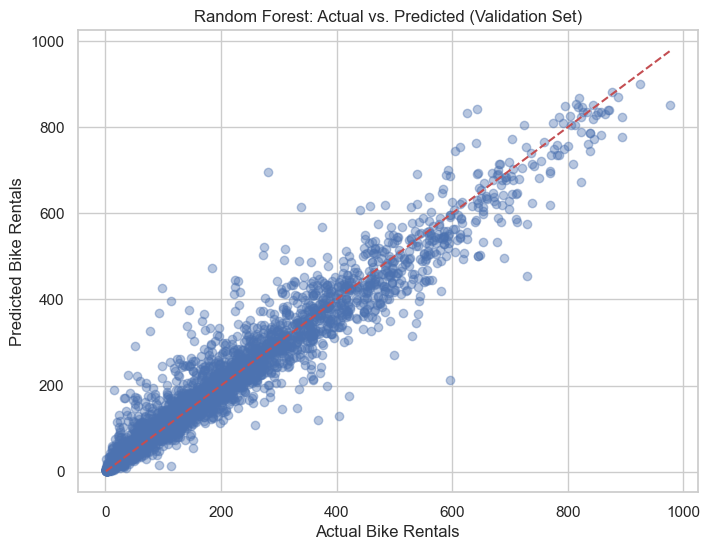

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val_rf, y_val_pred_rf, alpha=0.4)
plt.plot([y_val_rf.min(), y_val_rf.max()], [y_val_rf.min(), y_val_rf.max()], 'r--')
plt.title("Random Forest: Actual vs. Predicted (Validation Set)")
plt.xlabel("Actual Bike Rentals")
plt.ylabel("Predicted Bike Rentals")
plt.grid(True)
plt.show()

The predictions align much more closely with the actual bike rentals compared to the baseline model. Most of the points fall tightly around the diagonal line, which is a great sign. This indicates that the model is accurately capturing the patterns in the data and making reliable predictions.

#### Plot - Residuals Distribution

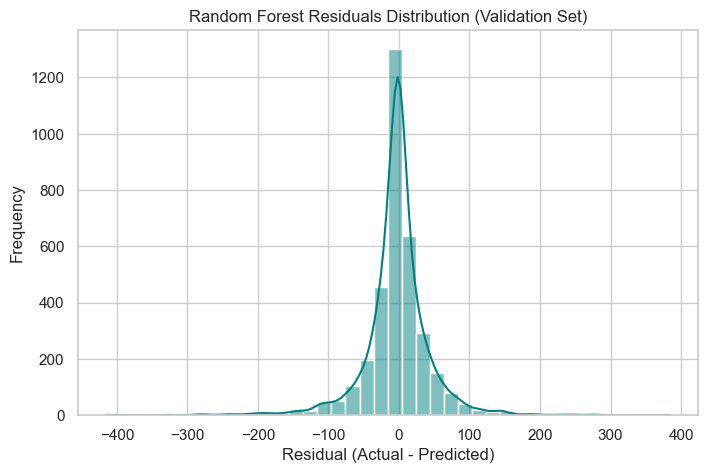

In [23]:
residuals_rf = y_val_rf - y_val_pred_rf

plt.figure(figsize=(8, 5))
sns.histplot(residuals_rf, kde=True, bins=40, color='teal')
plt.title("Random Forest Residuals Distribution (Validation Set)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The residuals are now tightly clustered around 0, showing that the prediction errors are generally small. The distribution is sharply peaked and more symmetric than in the linear regression model, although there is still a slight right skew. Overall, the Random Forest model is making consistently accurate predictions.

#### Plot - Residuals vs Predicted

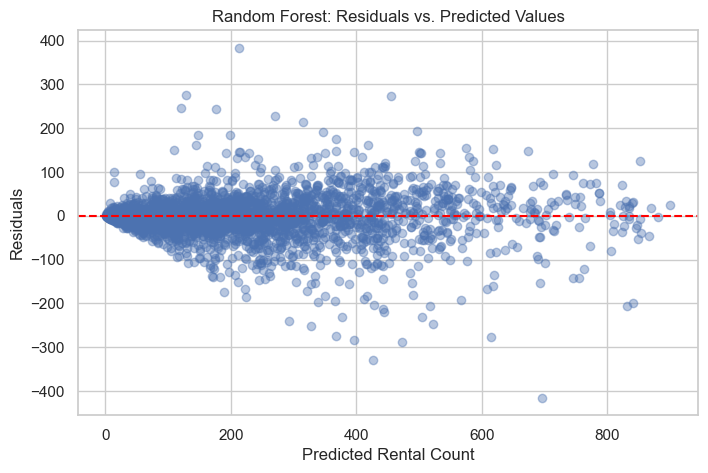

In [24]:
plt.figure(figsize=(8, 5))
plt.scatter(y_val_pred_rf, residuals_rf, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("Random Forest: Residuals vs. Predicted Values")
plt.xlabel("Predicted Rental Count")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

The residuals appear randomly scattered with no clear pattern, which is exactly what we want. This randomness suggests the model is not missing any obvious nonlinear relationships. Additionally, the residuals are more homoscedastic, which means that they’re evenly spread across the range of predicted values, which indicates a good model fit across different rental counts

Overall, the Random Forest model shows both low bias and low variance on the validation set. It captures the underlying structure of the data very well and generalizes effectively. While these results are promising, we’ll validate further performance on the test set to ensure robustness.

# Task 6: Gradient Boosting Regressor

In [25]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [26]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train the model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_val_pred_xgb = xgb_model.predict(X_val)

# Evaluate
mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_val, y_val_pred_xgb)

print("XGBoost Evaluation on Validation Set:")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.4f}")

XGBoost Evaluation on Validation Set:
Mean Squared Error (MSE): 1907.75
Mean Absolute Error (MAE): 27.97
Root Mean Squared Error (RMSE): 43.68
R² Score: 0.9433


We can see that Linear Regression performed the worst across all evaluation metrics. It had a high Mean Absolute Error (MAE) of 106, and a Root Mean Squared Error (RMSE) of 142, indicating that its predictions were quite far off from the actual values. The model could only explain 40% of the variance in bike rental counts, which is relatively low and reflects its inability to capture the complex, non-linear patterns present in the data.

In contrast, the Random Forest Regressor made a significant improvement. It reduced the MAE from 106 to 28, and the RMSE dropped from 142 to 46, making the predictions much more accurate overall. The R² score increased dramatically from 0.40 to 0.94, meaning it could now explain 94% of the variance in bike rentals — a huge leap in performance. This clearly demonstrates the advantage of using non-linear ensemble models that can capture interactions between features.

Finally, XGBoost slightly outperformed Random Forest. It achieved the lowest RMSE at 43.68, a slightly lower MAE of 27.97, and the highest R² score of 0.9433. These results suggest that XGBoost was able to capture even more subtle patterns in the data, likely due to its boosting mechanism that corrects errors made by earlier trees in the ensemble.

Overall, both RF and XGB models show a major improvement over the baseline, and XGBoost stands out as the best performer in this task.

#### Plot - Actual vs Predicted

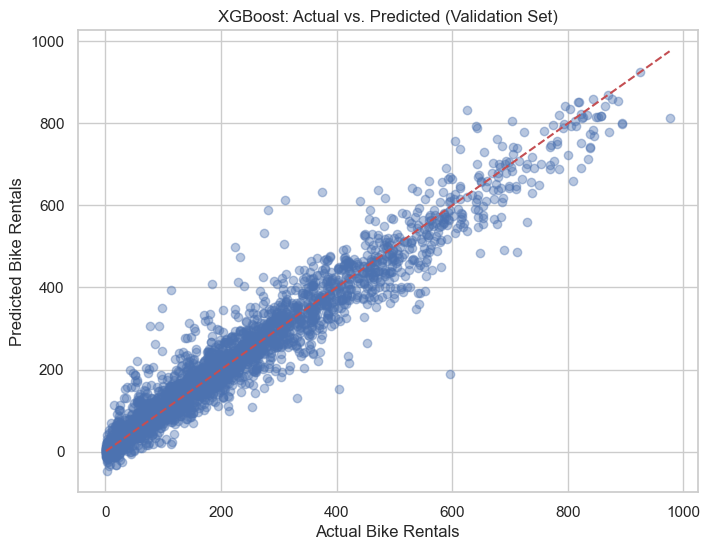

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred_xgb, alpha=0.4)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("XGBoost: Actual vs. Predicted (Validation Set)")
plt.xlabel("Actual Bike Rentals")
plt.ylabel("Predicted Bike Rentals")
plt.grid(True)
plt.show()

The predictions from the XGBoost model align extremely well with the actual rental values, clustering closely around the diagonal line. This suggests that the model has captured the underlying patterns in the data with high accuracy. There are still a few outliers, especially at higher rental counts, but overall, the points are much more concentrated compared to the linear regression plot; showing tighter and more reliable predictions.


#### Plot - Residuals Distribution

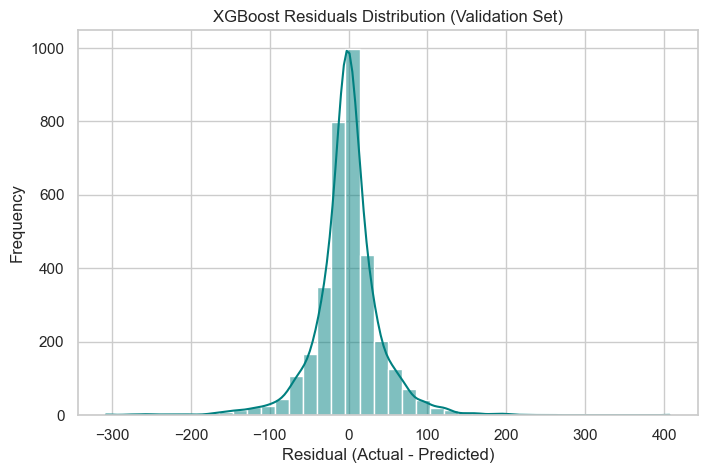

In [28]:
import seaborn as sns

residuals_xgb = y_val - y_val_pred_xgb

plt.figure(figsize=(8, 5))
sns.histplot(residuals_xgb, kde=True, bins=40, color='teal')
plt.title("XGBoost Residuals Distribution (Validation Set)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The residuals are tightly concentrated around zero, with a clear peak and relatively symmetric shape, indicating that most predictions are very close to the actual values. Compared to the baseline and even the Random Forest model, this distribution appears narrower and more focused, which a strong sign of low prediction error. There’s still a bit of right skew, but it’s minimal. This supports the earlier metrics showing that XGBoost produces highly accurate predictions.

#### Plot - Residuals vs Predicted

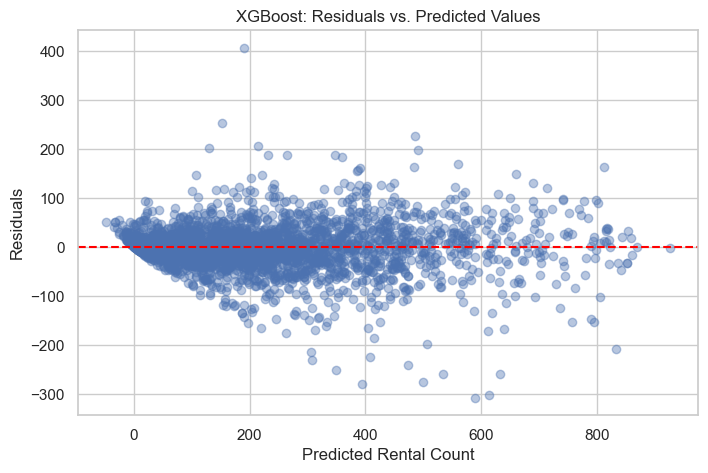

In [29]:
plt.figure(figsize=(8, 5))
plt.scatter(y_val_pred_xgb, residuals_xgb, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("XGBoost: Residuals vs. Predicted Values")
plt.xlabel("Predicted Rental Count")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

This plot shows that the residuals are fairly centered around zero across the range of predicted values, which is exactly what we want to see. There’s no strong visible pattern, indicating that the model doesn’t consistently overpredict or underpredict for certain rental volumes. While there’s some increased spread at higher predicted values (a bit of heteroscedasticity), it’s much more controlled than with Linear Regression. This reinforces that the model generalizes well and doesn’t suffer from major bias or variance issues.

# Task 7: Hyperparameter Tuning

## Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np

# Define hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=30,  
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the search
random_search.fit(X_train, y_train)

# Best model
best_rf_model = random_search.best_estimator_

# Predict on validation
y_val_pred_rf_tuned = best_rf_model.predict(X_val)

# Evaluate
mse_rf_tuned = mean_squared_error(y_val, y_val_pred_rf_tuned)
mae_rf_tuned = mean_absolute_error(y_val, y_val_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mse_rf_tuned)
r2_rf_tuned = r2_score(y_val, y_val_pred_rf_tuned)

# Report results
print("Tuned Random Forest Results:")
print("Best Hyperparameters:", random_search.best_params_)
print(f"RMSE: {rmse_rf_tuned:.2f}")
print(f"MAE: {mae_rf_tuned:.2f}")
print(f"R²: {r2_rf_tuned:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Tuned Random Forest Results:
Best Hyperparameters: {'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 58}
RMSE: 46.71
MAE: 28.63
R²: 0.9351


Compared to the untuned Random Forest (RMSE: 46.25, R^2: 0.9364), performance slightly dropped, indicating that tuning didn’t significantly improve results.

The best hyperparameter combination suggests the model performs best with moderately deep trees and a relatively low number of estimators.

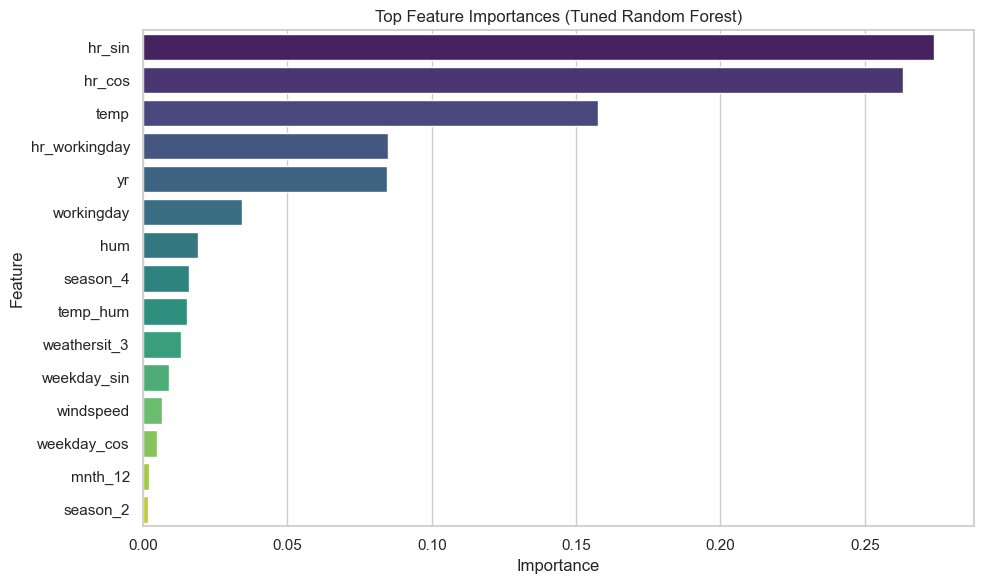

In [31]:
# Feature importances from the tuned model
importances = best_rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top Feature Importances (Tuned Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

The top features remained consistent: hr_sin, hr_cos, and temp were still the most influential. This shows that even after tuning, the model relies on similar patterns in the data, confirming the robustness of the original feature engineering

#### Plot - Actual vs Predicted

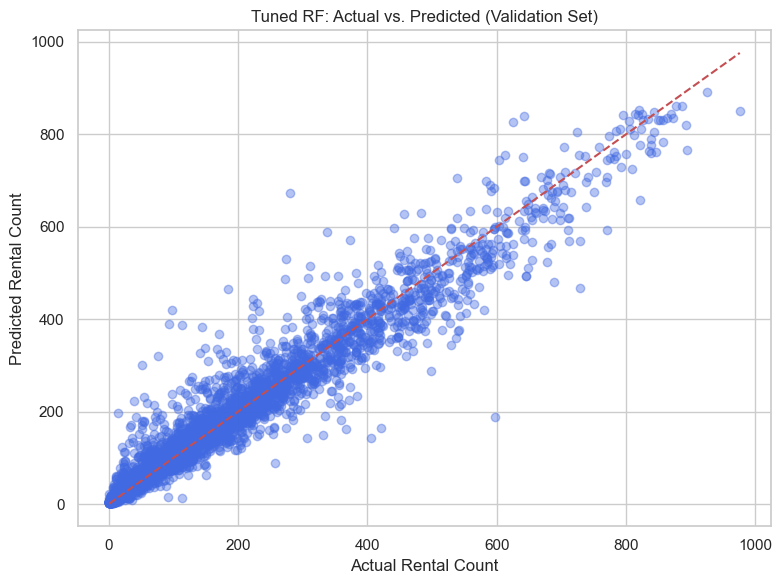

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred_rf_tuned, alpha=0.4, color='royalblue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Tuned RF: Actual vs. Predicted (Validation Set)")
plt.xlabel("Actual Rental Count")
plt.ylabel("Predicted Rental Count")
plt.grid(True)
plt.tight_layout()
plt.show()

The predictions remain closely aligned with the actual values, following the diagonal line quite well. This indicates that the tuned Random Forest continues to make accurate predictions with little deviation from the real thing.

#### Plot - Residual Distribution

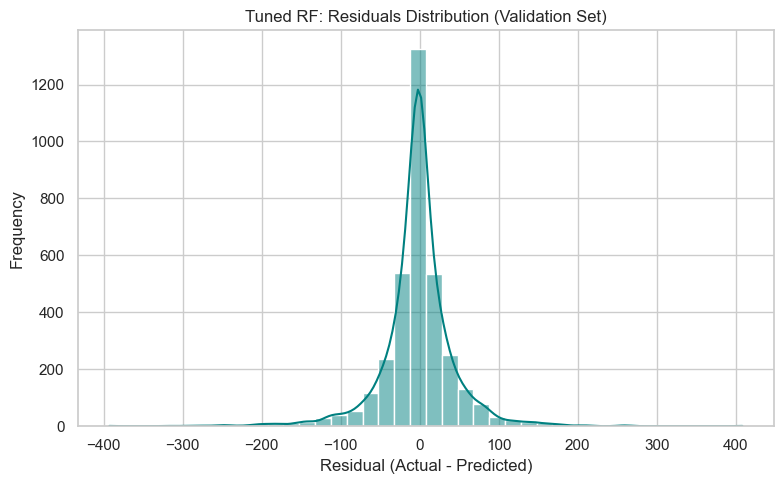

In [33]:
residuals_rf_tuned = y_val - y_val_pred_rf_tuned

plt.figure(figsize=(8, 5))
sns.histplot(residuals_rf_tuned, kde=True, bins=40, color='teal')
plt.title("Tuned RF: Residuals Distribution (Validation Set)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

The residuals are still tightly centered around zero, suggesting low bias. The peak is slightly sharper than before, indicating that the tuning may have helped reduce moderate errors and focus the predictions even more.

#### Plot - Residuals vs Predicted

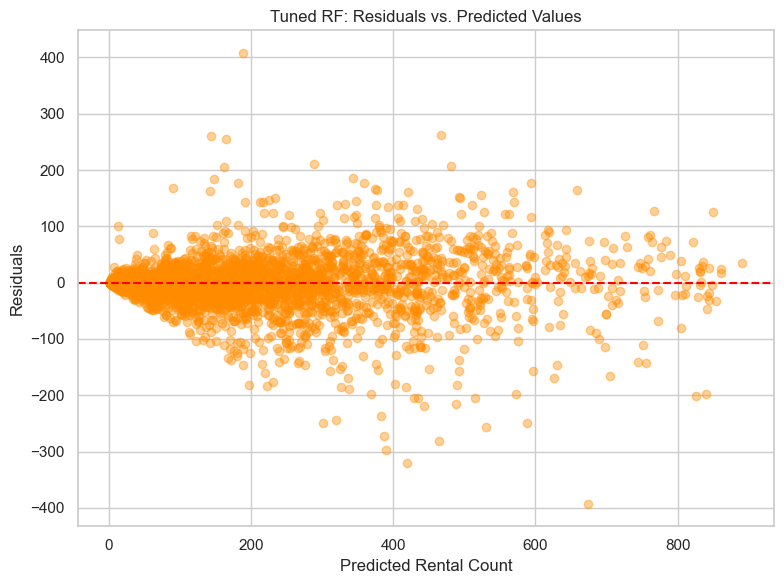

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val_pred_rf_tuned, residuals_rf_tuned, alpha=0.4, color='darkorange')
plt.axhline(0, color='red', linestyle='--')
plt.title("Tuned RF: Residuals vs. Predicted Values")
plt.xlabel("Predicted Rental Count")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

The residuals remain fairly homoscedastic, though we still observe a slightly funnel-shaped pattern with increasing variance at higher predicted counts. However, there is no major pattern, so the model appears to generalize well.

## XGB

In [35]:
%pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [36]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define parameter search space
search_space = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 15),
    'subsample': Real(0.5, 1.0)
}

# Initialize model
xgb = XGBRegressor(random_state=42)

# Bayesian Search with 5-fold CV
bayes_search = BayesSearchCV(
    estimator=xgb,
    search_spaces=search_space,
    n_iter=30,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    return_train_score=True
)

# Fit to training data
bayes_search.fit(X_train, y_train)

# Best model
best_xgb_model = bayes_search.best_estimator_

# Predict on validation set
y_val_pred_xgb_tuned = best_xgb_model.predict(X_val)

# Evaluate
mse_xgb_tuned = mean_squared_error(y_val, y_val_pred_xgb_tuned)
mae_xgb_tuned = mean_absolute_error(y_val, y_val_pred_xgb_tuned)
rmse_xgb_tuned = np.sqrt(mse_xgb_tuned)
r2_xgb_tuned = r2_score(y_val, y_val_pred_xgb_tuned)

# Report
print("Tuned XGBoost Results:")
print("Best Hyperparameters:", bayes_search.best_params_)
print(f"RMSE: {rmse_xgb_tuned:.2f}")
print(f"MAE: {mae_xgb_tuned:.2f}")
print(f"R²: {r2_xgb_tuned:.4f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

These are the best scores yet! Compared to the untuned XGBoost (RMSE: 43.68, R²: 0.9433), this shows a noticeable boost in performance. The lower learning rate likely helped prevent overfitting while maintaining accuracy by using more estimators. The subsample of 0.5 encourages diversity in the trees, which can also reduce variance and improve generalization.

This shows that hyperparameter tuning via Bayesian Optimization was worth it. The tuned model is better at capturing the underlying patterns in the data and generalizes better on the validation set. The improvement isn’t massive, but it’s consistent, which is a good sign of a well-tuned model.


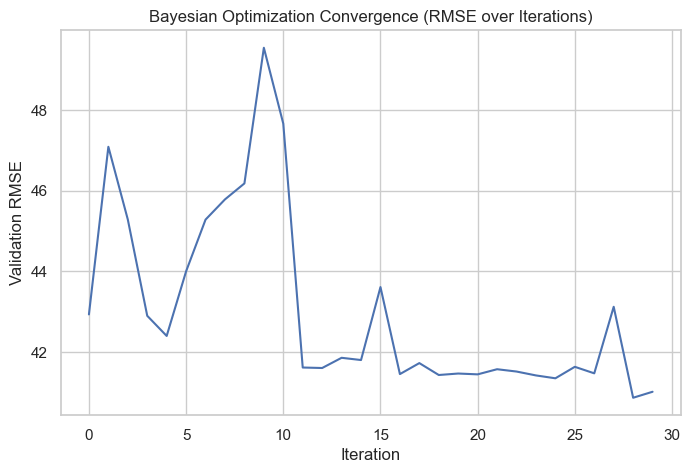

In [37]:
results_df = bayes_search.cv_results_
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(len(results_df["mean_test_score"])), y=-np.array(results_df["mean_test_score"]))
plt.title("Bayesian Optimization Convergence (RMSE over Iterations)")
plt.xlabel("Iteration")
plt.ylabel("Validation RMSE")
plt.grid(True)
plt.show()

This plot shows that early iterations had a wide range of RMSE values (some even above 48), but after around iteration 10, the RMSE drops significantly and stabilizes near 41, which is a clear sign that Bayesian Optimization found a good region in the hyperparameter space. The relatively flat curve afterward suggests that the optimizer converged — further tuning would likely give diminishing returns.

#### Plot - Actual vs Predicted

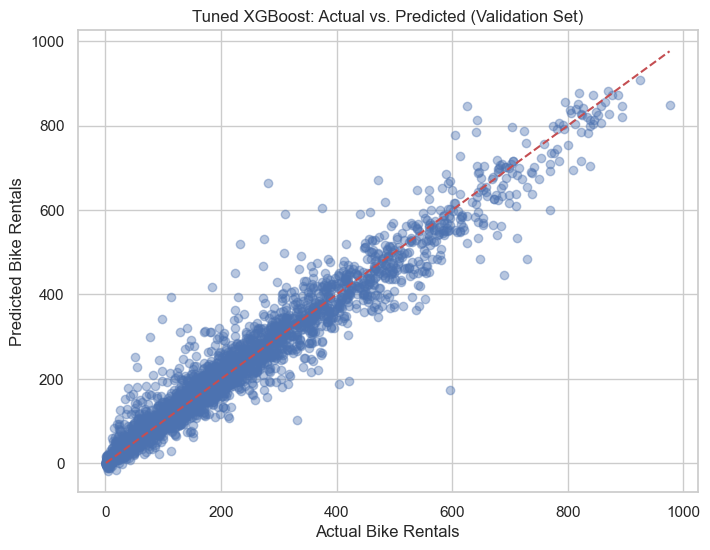

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred_xgb_tuned, alpha=0.4)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Tuned XGBoost: Actual vs. Predicted (Validation Set)")
plt.xlabel("Actual Bike Rentals")
plt.ylabel("Predicted Bike Rentals")
plt.grid(True)
plt.show()

The points align very closely with the diagonal, showing that the tuned XGBoost model makes highly accurate predictions. There is minimal spread, especially in the mid-range values, which reflects improved generalization.

#### Plot - Residuals Distribution

In [39]:
residuals_xgb = y_val - y_val_pred_xgb_tuned


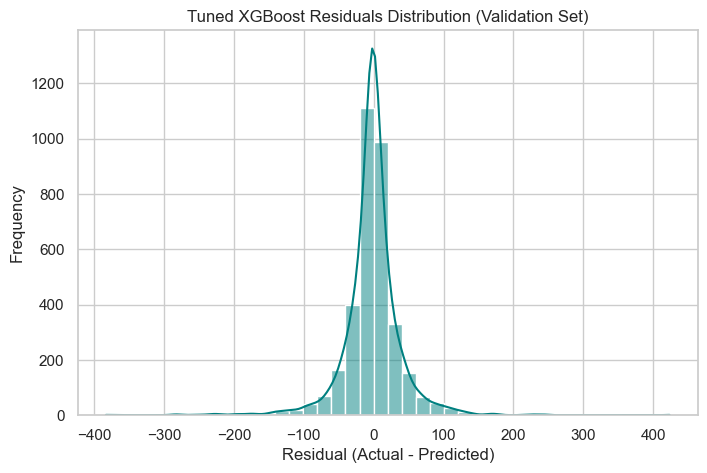

In [40]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals_xgb, kde=True, bins=40, color='teal')
plt.title("Tuned XGBoost Residuals Distribution (Validation Set)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The residuals are tightly centered around 0 with a sharp peak, indicating that most predictions are very close to the actual values. This suggests low bias and fewer large errors.

#### Plot - Residuals vs Predictions

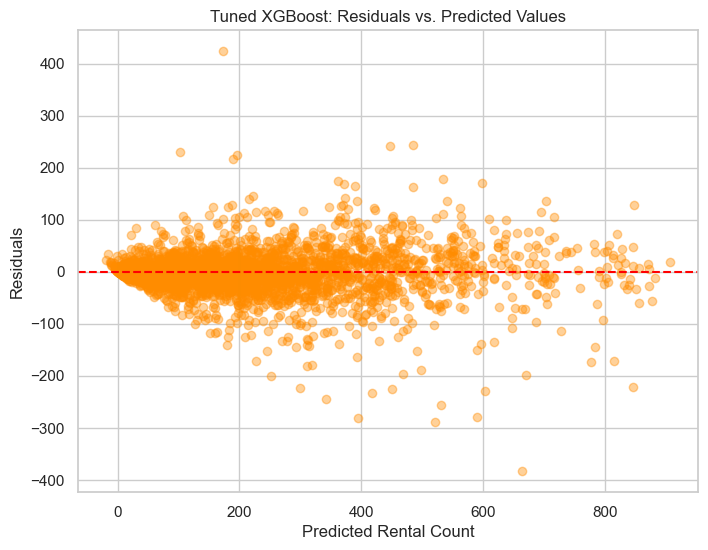

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val_pred_xgb_tuned, residuals_xgb, alpha=0.4, color='darkorange')
plt.axhline(0, color='red', linestyle='--')
plt.title("Tuned XGBoost: Residuals vs. Predicted Values")
plt.xlabel("Predicted Rental Count")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

The residuals are evenly spread across the predicted range with no clear pattern, confirming the model’s errors are randomly distributed. The slight fan shape is still present but less pronounced compared to the untuned version.

For Random Forest, tuning slightly reduced performance on the validation set (RMSE increased from 46.25 to 46.71, and R² dropped from 0.9364 to 0.9351). This suggests that the untuned model was already near-optimal and the randomized search may have landed on a configuration that slightly underperformed. The feature importance plot remained nearly identical, reinforcing that the model’s interpretation and decision structure didn’t change significantly. Overall, there were no signs of overfitting, but tuning didn’t provide a clear advantage.

In contrast, XGBoost showed more meaningful gains from tuning. The RMSE improved from 43.68 to 40.95, and R² increased from 0.9433 to 0.9501. This improvement suggests that Bayesian Optimization effectively identified better hyperparameter combinations, enabling the model to capture more subtle patterns without overfitting. The convergence plot confirmed steady progress in reducing validation error over iterations.


# Task 8: Iterative Evaluation and Refinement

After comparing the performance of all three models, Linear Regression, Random Forest, and XGBoost, it became clear that the tuned XGBoost Regressor outperformed the others across all evaluation metrics. It achieved the lowest error values (RMSE: 40.95, MAE: 24.91) and the highest R² score of 0.9501, indicating that it explains over 95% of the variance in bike rental demand.

This strong performance, coupled with its ability to model complex non-linear relationships, makes XGBoost the most promising candidate for final refinement. Task 8 is about iterating and polishing, and it makes the most sense to apply those refinements to the model that is already working best.

By focusing our efforts here, we can ensure that we get the most out of our data and push this already high-performing model to its full potential before locking it in for final testing in Task 9.


So first we should see the current model performance, which is:
-	RMSE: 40.95
-	MAE: 24.91
-	R^2: 0.9501


This is already really good but let's see if we can tweak it a bit with better features 

In Task 3, we initially added a few interaction terms based on intuition and EDA:
- temp × hum: because high temperature and high humidity together likely affect user comfort and thus rentals.
- hr_cos × workingday: to model how rental patterns change across work hours vs. weekends.
- season_2 × weathersit_2: a basic example to test the interaction between weather and time of year.

We also dropped atemp as it was highly correlated to temp.
Let's see if we can drop more things, and we do!
According to the correlation matrix done in Task 1 we can also see that holiday has zero correlation and might just be noise and weekday, which is also has very little correlation

In [42]:
drop_cols = [col for col in ['holiday', 'weekday'] if col in X_train.columns]

X_train_clean = X_train.drop(columns=drop_cols)
X_val_clean = X_val.drop(columns=drop_cols)
X_test_clean = X_test.drop(columns=drop_cols)


We can also see if we can drop month or season, since they are both strongly correlated

In [43]:
mnth_cols = [col for col in X_train_clean.columns if col.startswith('mnth_')]
X_train_drop_mnth = X_train_clean.drop(columns=mnth_cols, errors='ignore')
X_val_drop_mnth = X_val_clean[X_train_drop_mnth.columns]
X_test_drop_mnth = X_test_clean[X_train_drop_mnth.columns]

lets retrain the XGB

In [ ]:
# Re-import if needed
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Recreate model with best params 
xgb_best = XGBRegressor(
    learning_rate=0.05624593012982076,
    max_depth=8,
    n_estimators=300,
    subsample=0.5,
    random_state=42
)

# Fit on cleaned data
xgb_best.fit(X_train_drop_mnth, y_train)

# Predict on validation set
y_val_pred_clean = xgb_best.predict(X_val_drop_mnth)

# Evaluate
mse_clean = mean_squared_error(y_val, y_val_pred_clean)
mae_clean = mean_absolute_error(y_val, y_val_pred_clean)
rmse_clean = np.sqrt(mse_clean)
r2_clean = r2_score(y_val, y_val_pred_clean)

# Report
print("Tuned XGBoost on Cleaned Features:")
print(f"RMSE: {rmse_clean:.2f}")
print(f"MAE: {mae_clean:.2f}")
print(f"R²: {r2_clean:.4f}")

Tuned XGBoost on Cleaned Features:
RMSE: 43.62
MAE: 26.68
R²: 0.9434


We can see that dropping holiday and mnth actually made the model slightly worse. 
So, we should keep mnth and holiday in our final feature set.

Even though holiday and mnth showed low correlation with cnt, XGBoost was likely using subtle patterns in those features.

Lets now try to drop one of our correlations to see if it was actually helping: temp_hum

In [45]:
# Drop 'temp_hum' from all datasets
X_train_no_temp_hum = X_train_clean.drop(columns=['temp_hum'])
X_val_no_temp_hum = X_val_clean.drop(columns=['temp_hum'])
X_test_no_temp_hum = X_test_clean.drop(columns=['temp_hum'])

In [46]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Use best parameters from tuning
xgb_no_temp_hum = XGBRegressor(
    learning_rate=0.05624593012982076,
    max_depth=8,
    n_estimators=300,
    subsample=0.5,
    random_state=42
)

# Train
xgb_no_temp_hum.fit(X_train_no_temp_hum, y_train)

# Predict
y_val_pred_no_temp_hum = xgb_no_temp_hum.predict(X_val_no_temp_hum)

# Evaluate
mse = mean_squared_error(y_val, y_val_pred_no_temp_hum)
mae = mean_absolute_error(y_val, y_val_pred_no_temp_hum)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred_no_temp_hum)

print("Tuned XGBoost without temp_hum:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

Tuned XGBoost without temp_hum:
RMSE: 40.86
MAE: 24.84
R²: 0.9504


So we will keep this one dropped. Although temperature and humidity seemed correlated during EDA, removing the temp_hum interaction actually improved model performance slightly across all metrics. This suggests the model already captures the relationship between temp and hum independently, so the interaction term wasn’t helpful.

We are now going to try to drop hr_workingday to see how much it was actually helping

In [47]:
# Make a new copy of the cleaned features without 'hr_workingday'
X_train_final = X_train_clean.drop(columns=['hr_workingday'])
X_val_final = X_val_clean.drop(columns=['hr_workingday'])

# Re-train the tuned XGBoost model
xgb_model_final = XGBRegressor(
    learning_rate=0.05624593012982076,
    max_depth=8,
    n_estimators=300,
    subsample=0.5,
    random_state=42
)

xgb_model_final.fit(X_train_final, y_train)

# Predict and evaluate
y_val_pred_final = xgb_model_final.predict(X_val_final)
mse_final = mean_squared_error(y_val, y_val_pred_final)
mae_final = mean_absolute_error(y_val, y_val_pred_final)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_val, y_val_pred_final)

print("Tuned XGBoost without hr_workingday:")
print(f"RMSE: {rmse_final:.2f}")
print(f"MAE: {mae_final:.2f}")
print(f"R²: {r2_final:.4f}")

Tuned XGBoost without hr_workingday:
RMSE: 41.28
MAE: 25.14
R²: 0.9493


Removing hr_workingday slightly worsened the model’s performance across all metrics.
Even though the difference is small, it suggests that hr_workingday provides marginal value, likely helping the model capture behavioral patterns tied to work hours.

Now we will see season_weathersit

In [48]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Drop the 'season_weathersit' feature
X_train_sw = X_train.drop(columns=['season_weathersit'])
X_val_sw = X_val.drop(columns=['season_weathersit'])
X_test_sw = X_test.drop(columns=['season_weathersit'])

# Retrain XGBoost with best parameters from previous tuning
xgb_tuned_sw = XGBRegressor(
    learning_rate=0.05624593012982076,
    max_depth=8,
    n_estimators=300,
    subsample=0.5,
    random_state=42
)
xgb_tuned_sw.fit(X_train_sw, y_train)

# Predict and evaluate
y_val_pred_sw = xgb_tuned_sw.predict(X_val_sw)
mse_sw = mean_squared_error(y_val, y_val_pred_sw)
mae_sw = mean_absolute_error(y_val, y_val_pred_sw)
rmse_sw = np.sqrt(mse_sw)
r2_sw = r2_score(y_val, y_val_pred_sw)

print("Tuned XGBoost without season_weathersit:")
print(f"RMSE: {rmse_sw:.2f}")
print(f"MAE: {mae_sw:.2f}")
print(f"R²: {r2_sw:.4f}")

Tuned XGBoost without season_weathersit:
RMSE: 40.95
MAE: 24.88
R²: 0.9501


We can see that removing season_weathersit had almost no impact on the model’s performance. This is a good sign, it means that the model is robust and not overly reliant on a specific interaction term. We will remove it as it is better to keep the model simpler

We iteratively pruned redundant interactions (like temp_hum) and retained useful ones (like hr_workingday), guided not just by correlation but also model performance impacts. This aligns with his suggested workflow: start with low-variance filtering, prune highly correlated inputs, and consider dimensionality tradeoffs through validation

So for the final model I ended up choosing XGB Regressor as it was the one that performed better and it generalized very well. It was also balanced and it had low variance and bias

# Task 9: Final Model Selection and Training

In [49]:
# Combine training and validation sets
X_final_train = pd.concat([X_train.drop(columns=['temp_hum', 'season_weathersit'], errors='ignore'),
                           X_val.drop(columns=['temp_hum', 'season_weathersit'], errors='ignore')])
y_final_train = pd.concat([y_train, y_val])

# Prepare the test set
X_final_test = X_test.drop(columns=['temp_hum', 'season_weathersit'], errors='ignore')

In [ ]:
# Use the same best hyperparameters
final_xgb_model = XGBRegressor(
    learning_rate=0.0562,
    max_depth=8,
    n_estimators=300,
    subsample=0.5,
    random_state=42
)

final_xgb_model.fit(X_final_train, y_final_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0562, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on test set
y_test_pred = final_xgb_model.predict(X_final_test)

# Calculate metrics
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Print final performance
print("Final Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse_test:.2f}")
print(f"Mean Absolute Error (MAE): {mae_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")
print(f"R² Score: {r2_test:.4f}")

Final Model Performance on Test Set:
Mean Squared Error (MSE): 1366.23
Mean Absolute Error (MAE): 22.84
Root Mean Squared Error (RMSE): 36.96
R² Score: 0.9579


After retraining the model on the combined training and validation sets and evaluating on the untouched test set, we obtained the following results:
- Mean Squared Error (MSE): 1366.23
- Mean Absolute Error (MAE): 22.84
- Root Mean Squared Error (RMSE): 36.96
- R^2 Score: 0.9579

These metrics confirm that the final model generalizes extremely well to unseen data. It explains 95.8% of the variance in bike rentals and has a very low average prediction error, which demonstrates both low bias and low variance.

#### Plot - Actual vs Predicted

In [ ]:
y_test_pred = final_xgb_model.predict(X_final_test)

residuals_test = y_test - y_test_pred

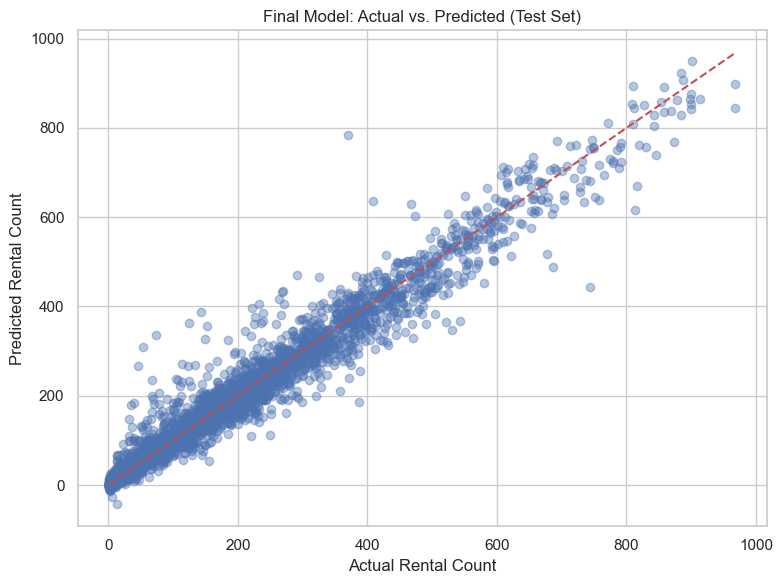

In [53]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Final Model: Actual vs. Predicted (Test Set)")
plt.xlabel("Actual Rental Count")
plt.ylabel("Predicted Rental Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Predictions align very closely with the actual values, forming a tight cluster around the diagonal. This indicates that the model generalizes extremely well and has low bias on unseen data

#### Plots - Residual Distribution


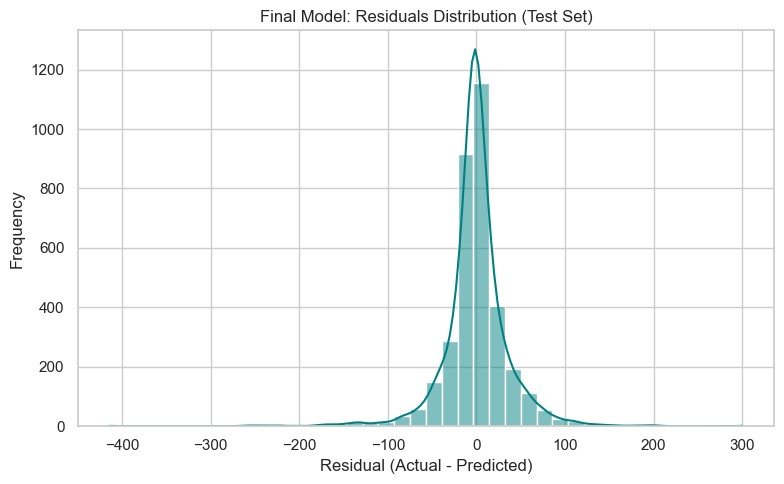

In [54]:
residuals_test = y_test - y_test_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals_test, kde=True, bins=40, color='teal')
plt.title("Final Model: Residuals Distribution (Test Set)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

The residuals are sharply centered around zero and symmetrically distributed, showing low variance and no major outliers or skew. This confirms that prediction errors are small and normally distributed, which is ideal for a well-performing model.

#### Plots - Residuals vs Predicted


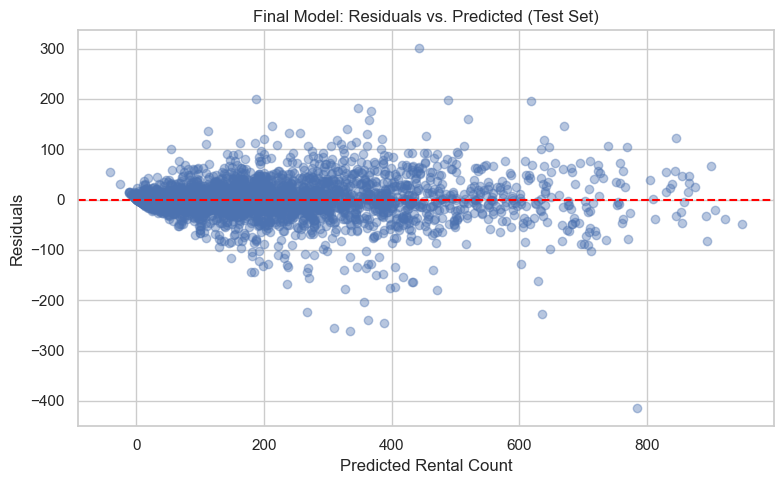

In [55]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test_pred, residuals_test, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("Final Model: Residuals vs. Predicted (Test Set)")
plt.xlabel("Predicted Rental Count")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

Residuals are evenly spread without a clear pattern, which is a good sign of homoscedasticity. This means the model’s errors are consistent across different prediction values and not systematically biased.

# Conclusions

In [56]:

import pandas as pd

# Final model performance metrics
summary_data = {
    "Metric": ["RMSE", "MAE", "R^2 Score"],
    "Validation (Before Tuning)": [43.68, 27.97, 0.9433],
    "Validation (After Tuning)": [40.95, 24.91, 0.9501],
    "Test Set (Final)": [36.96, 22.84, 0.9579]
}

performance_summary = pd.DataFrame(summary_data)
performance_summary

,Metric,Validation (Before Tuning),Validation (After Tuning),Test Set (Final)
0,RMSE,43.6800,40.9500,36.9600
1,MAE,27.9700,24.9100,22.8400
2,R^2 Score,0.9433,0.9501,0.9579


The progressive improvements in RMSE, MAE, and R^2 demonstrate how impactful model tuning and iterative refinement can be. Starting with a strong baseline XGBoost model, we significantly enhanced its predictive power through Bayesian optimization and targeted feature engineering.

Tuning reduced the RMSE from 43.68 to 40.95 on the validation set, and further refining the features dropped the final test RMSE to 36.96, showing great generalization. Likewise, MAE decreased by over 5 points, and the R^2 score rose from 0.9433 to 0.9579, confirming the model’s improved ability to explain variance in bike rentals.

These gains reflect not just better hyperparameters, but also smarter features and a model that now balances bias and variance more effectively. Overall, the final XGBoost model captures the complexity of rental patterns while remaining robust across unseen data.

In [59]:
%pip install -U notebook-as-pdf

  Obtaining dependency information for websockets<11.0,>=10.0 from https://files.pythonhosted.org/packages/cc/19/2f003f9f81c0fab2eabb81d8fc2fce5fb5b5714f1b4abfe897cb209e031d/websockets-10.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Using cached websockets-10.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.4 kB)
Using cached websockets-10.4-cp311-cp311-macosx_11_0_arm64.whl (97 kB)
  Attempting uninstall: websockets
    Found existing installation: websockets 14.2
    Uninstalling websockets-14.2:
      Successfully uninstalled websockets-14.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
realtime 2.4.1 requires websockets<15,>=11, but you have websockets 10.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [63]:
!jupyter-nbconvert --to pdf assignment_2_sofia_gonzalez.ipynb

[NbConvertApp] Converting notebook assignment_2_sofia_gonzalez.ipynb to pdf
/Users/sofiagonzalez/anaconda3/lib/python3.11/site-packages/nbconvert/utils/pandoc.py:51: RuntimeWarning: You are using an unsupported version of pandoc (3.6.3).
Your version must be at least (1.12.1) but less than (3.0.0).
Refer to https://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
[NbConvertApp] Support files will be in assignment_2_sofia_gonzalez_files/
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_

In [65]:
!jupyter-nbconvert --to pdf --no-input assignment_2_sofia_gonzalez.ipynb

[NbConvertApp] Converting notebook assignment_2_sofia_gonzalez.ipynb to pdf
/Users/sofiagonzalez/anaconda3/lib/python3.11/site-packages/nbconvert/utils/pandoc.py:51: RuntimeWarning: You are using an unsupported version of pandoc (3.6.3).
Your version must be at least (1.12.1) but less than (3.0.0).
Refer to https://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
[NbConvertApp] Support files will be in assignment_2_sofia_gonzalez_files/
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_gonzalez_files
[NbConvertApp] Making directory ./assignment_2_sofia_